In [146]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from calendar import monthrange
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, SelectFdr, f_regression

# For calculating feature wise distribution similarity
from scipy.spatial.distance import jensenshannon as js_dist

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Global Parameters

In [147]:
TARGET = 'LoadFactor'

# For loading data
REALIZED_DATA_PATH = 'dataset_full.xls'
FUTURE_DATA_PATH = 'future_data.xls'

# For saving data
DATA_FOLDER = 'data'

if not os.path.exists:
    os.mkdir(DATA_FOLDER)

TRAIN_PATH = os.path.join(DATA_FOLDER, 'train.csv')
VALIDATION_PATH = os.path.join(DATA_FOLDER, 'validation.csv')
TEST_PATH = os.path.join(DATA_FOLDER, 'test.csv')
FUTURE_PATH = os.path.join(DATA_FOLDER, 'future_preprocessed.csv')

# Data Preprocessing of Case 1
### By August Semrau and William Marstrand
This notebook consists of data preprocessing, analysis and modelling is found in seperate notebooks

## Data

In [148]:
df_realized = pd.read_excel(REALIZED_DATA_PATH)
df_realized

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...
39444,2022-02-28 18:45:00,VW,986,YYZ,319,J,CA,144,0.847222
39445,2022-02-28 19:25:00,LJ,667,YDQ,319,J,CA,156,0.871795
39446,2022-02-28 20:00:00,VW,3406,MYV,E90,J,US,98,0.857143
39447,2022-02-28 19:30:00,LJ,663,RUT,32N,J,US,186,0.682796


In [149]:
df_future = pd.read_excel(FUTURE_DATA_PATH)
df_future

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity
0,2022-03-01 05:45:00,UK,1315,YXX,319,J,CA,131
1,2022-03-01 07:15:00,PW,950,YLW,319,J,CA,143
2,2022-03-01 06:45:00,VW,770,YYZ,320,J,CA,220
3,2022-03-01 06:40:00,DO,2568,YXU,32N,J,CA,180
4,2022-03-01 07:30:00,AY,984,YYG,320,J,CA,174
...,...,...,...,...,...,...,...,...
4808,2022-03-31 21:05:00,SV,1988,YYJ,73H,J,CA,186
4809,2022-03-31 20:55:00,MD,1242,YBR,321,J,CA,230
4810,2022-03-31 21:50:00,LJ,506,YUL,320,J,CA,186
4811,2022-03-31 20:30:00,LJ,772,YEG,320,J,CA,186


First we combine the two datasets to make sure they are preprocessed to have the same features

In [150]:
data = pd.concat([df_realized, df_future])
data

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...
4808,2022-03-31 21:05:00,SV,1988,YYJ,73H,J,CA,186,NaN
4809,2022-03-31 20:55:00,MD,1242,YBR,321,J,CA,230,NaN
4810,2022-03-31 21:50:00,LJ,506,YUL,320,J,CA,186,NaN
4811,2022-03-31 20:30:00,LJ,772,YEG,320,J,CA,186,NaN


We convert the flight number to an object type, since it is really a categorical variable, but Pandas thinks it's numerical

In [151]:
## Convert FlightNumber to object, it is not a numerical value
data.FlightNumber = data.FlightNumber.astype(object)
## Investigate data for dtypes and stuff
print('\ndtypes of the datasets columns:')
data.dtypes


dtypes of the datasets columns:


ScheduleTime    datetime64[ns]
Airline                 object
FlightNumber            object
Destination             object
AircraftType            object
FlightType              object
Sector                  object
SeatCapacity             int64
LoadFactor             float64
dtype: object

In [152]:
INPUT_FEATURES = data.columns.drop(TARGET)
INPUT_FEATURES

Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity'],
      dtype='object')

## Data Cleaning
We clean the data based on the input variables. **We do not look at the target variable LoadFactor**.
<br>
We want to first make sure that the data itself is sane before we go any further and start extracting new features from the data.
<br>
The checks we do are:
* Checking for and cleaning null values
* Checking for illegal values e.g. zero or negative seat capacity or impossible dates in ScheduleTime
* Checking for and possibly removing outliers

### Null Values

In [153]:
def remove_empty(df):
    nan_values_count = df.isnull().sum()
    empty_values_count = df.apply(lambda df: df == '', axis=1).sum()
    print(f'List of null/empty data counts for each column: \n{nan_values_count+empty_values_count}')

    ## As there are so few missing values, a total of five rows, we simply remove these
    df_no_nan = df.dropna()[df.apply(lambda df: df != '')]
    # rea_df = rea_df.loc[rea_df['FlightType'].isin(['C', 'J'])]
    print(f'\nData had {df.shape[0]} rows pre-nan-removal, now has {df_no_nan.shape[0]} rows.')

    return df_no_nan
    

In [154]:
no_nan_data = data.copy()
no_nan_data[INPUT_FEATURES] = remove_empty(data[INPUT_FEATURES])

List of null/empty data counts for each column: 
ScheduleTime    0
Airline         0
FlightNumber    0
Destination     0
AircraftType    0
FlightType      0
Sector          0
SeatCapacity    0
dtype: int64

Data had 44262 rows pre-nan-removal, now has 44262 rows.


### Illegal or Extremely Unlikly Values

In [155]:
def is_before_2021_or_in_the_future(df):
    min_st = pd.Timestamp(2021, 1, 1)
    max_st = pd.Timestamp(2022, 4, 1)
    return df['ScheduleTime'].apply(lambda st: st < min_st or st >= max_st)

In [156]:
# Check if any ScheduleTime in Realized dataset is before 2021 or into the future
data[is_before_2021_or_in_the_future(data)]

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor


In [157]:
def is_negative_or_zero(df):
    return df['SeatCapacity'] <= 0

In [158]:
# Check if Realized SeatCapacity is zero or negative
data[is_negative_or_zero(data)]

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor


In [159]:
# Check if LoadFactors are low or very high
print(f'Min LoadFactor: {data[TARGET].min()}')
print(f'Max LoadFactor: {data[TARGET].max()}')

Min LoadFactor: 0.0
Max LoadFactor: 1.47517730496453


So no negative load factors.
And we have some load factors which are greater than 1 indicating that the flight has more passengers than seats. While it might be tempting to remove these records on the basis of illegal data, we are keeping them due to the fact, that we understand the description of the LoadFactor variable to mean the share of occupied seats meaning that a load factor greater than 1 just indicates an overbooking for the flight. Overbooking is a generally used practice as described in this [article](https://www.aeroclass.org/why-are-airlines-allowed-to-overbook/) and as such we accept the data.
<br>
Also, som flights are empty or close to empty, but as explained in this [article](https://eu.usatoday.com/story/travel/columnist/cox/2019/08/14/ask-captain-why-fly-plane-just-one-passenger/2006241001/) this is also a perfectly valid scenario.

## Feature Engineering
Based on the different data types, we already know we want to do a couple of things to each column/feature, and these are described below:
<br><br>
For **ScheduleTime**, we want to do two things; Firstly, we want to convert the datetime64[ns] format to a more simple datetime format. We further want to create new object columns; one which encodes which year it is, one for the month of the year the flight is, which week, weekday, hour of day and minute of hour. These will also be encoded in the next step.
These new features extrated from the timestamp will be categorical features.
<br><br>
For **Airline**, **Flightnumber** (infact categorical), **Destination**, **Aircrafttype**, **Flighttype** and **Sector**, columns which are encoded as objects (they are categorical), we need to make an alternative encoding.
<br><br>
SeatCapacity is made categorical, though it differently from the rest, is in fact ordinal.

### Extracting Features from **ScheduleTime**
The `ScheduleTime` feature is a `datetime64` dtype. To be able to use it in a meaningful way for the modelling, we extract certain time features from it e.g. `Year`, `Month`, `Day`, and `WeekNumber`.

In [160]:
def get_season(month):
    if month >= 3 and month <= 5:
        return 'Spring'
    elif month >= 6 and month <= 8:
        return 'Summer'
    elif month >= 9 and month <= 11:
        return 'Fall'
    elif month == 12 or (month >= 1 and month <= 2):
        return 'Winter'
    else:
        raise Exception(f'Invalid month {month}')

def extract_scheduletime_features(df):
    df = df.copy()
    ### Preprosses time for getting year, month, week number, weekday, hour of day and minute of hour
    df['Year'] = df['ScheduleTime'].dt.year
    df['Month'] = df['ScheduleTime'].dt.month
    df['WeekNumber'] = df['ScheduleTime'].dt.week
    df['Weekday'] = df['ScheduleTime'].dt.dayofweek
    df['HourOfDay'] = df['ScheduleTime'].dt.hour
    df['MinuteOfHour'] = df['ScheduleTime'].dt.minute
    df['Season'] = df['ScheduleTime'].dt.month.apply(get_season)

    df.Year = df.Year.astype(object)
    df.Month = df.Month.astype(object)
    df.WeekNumber = df.WeekNumber.astype(object)
    df.Weekday = df.Weekday.astype(object)
    df.HourOfDay = df.HourOfDay.astype(object)
    df.MinuteOfHour = df.MinuteOfHour.astype(object)
    df.Season = df.Season.astype(object)

    return df

In [161]:
data_schedule_time = extract_scheduletime_features(no_nan_data)
data_schedule_time = data_schedule_time.drop('ScheduleTime', axis=1)
data_schedule_time

,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor,Year,Month,WeekNumber,Weekday,HourOfDay,MinuteOfHour,Season
0,IA,874,DEN,73W,J,US,142,0.408451,2021,1,53,4,6,35,Winter
1,JZ,818,YHM,AT7,J,CA,74,0.189189,2021,1,53,4,10,35,Winter
2,IA,876,DEN,73W,J,US,142,0.570423,2021,1,53,4,12,5,Winter
3,CN,514,EST,AT7,J,US,72,0.333333,2021,1,53,4,13,20,Winter
4,LJ,3140,DEN,32A,J,US,186,0.204301,2021,1,53,4,14,20,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,SV,1988,YYJ,73H,J,CA,186,NaN,2022,3,13,3,21,5,Spring
4809,MD,1242,YBR,321,J,CA,230,NaN,2022,3,13,3,20,55,Spring
4810,LJ,506,YUL,320,J,CA,186,NaN,2022,3,13,3,21,50,Spring
4811,LJ,772,YEG,320,J,CA,186,NaN,2022,3,13,3,20,30,Spring


### Departures
We also compute some new features around departures

In [162]:
dated_data = data_schedule_time.copy()
# Totals
daily_departures = dated_data.groupby(['Year', 'WeekNumber', 'Weekday']).size().reset_index(name='TotalDeparturesDay')
weekly_departures = dated_data.groupby(['Year', 'WeekNumber']).size().reset_index(name='TotalDeparturesWeek')
monthly_departures = dated_data.groupby(['Year', 'Month']).size().reset_index(name='TotalDeparturesMonth')

daily_data = dated_data.join(daily_departures.set_index(['Year', 'WeekNumber', 'Weekday']), on=['Year', 'WeekNumber', 'Weekday'], how='left')
weekly_data = daily_data.join(weekly_departures.set_index(['Year', 'WeekNumber']), on=['Year', 'WeekNumber'], how='left')
monthly_data = weekly_data.join(monthly_departures.set_index(['Year', 'Month']), on=['Year', 'Month'], how='left')
monthly_data

,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor,Year,Month,WeekNumber,Weekday,HourOfDay,MinuteOfHour,Season,TotalDeparturesDay,TotalDeparturesWeek,TotalDeparturesMonth
0,IA,874,DEN,73W,J,US,142,0.408451,2021,1,53,4,6,35,Winter,25,144,1010
1,JZ,818,YHM,AT7,J,CA,74,0.189189,2021,1,53,4,10,35,Winter,25,144,1010
2,IA,876,DEN,73W,J,US,142,0.570423,2021,1,53,4,12,5,Winter,25,144,1010
3,CN,514,EST,AT7,J,US,72,0.333333,2021,1,53,4,13,20,Winter,25,144,1010
4,LJ,3140,DEN,32A,J,US,186,0.204301,2021,1,53,4,14,20,Winter,25,144,1010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,SV,1988,YYJ,73H,J,CA,186,NaN,2022,3,13,3,21,5,Spring,209,805,4813
4809,MD,1242,YBR,321,J,CA,230,NaN,2022,3,13,3,20,55,Spring,209,805,4813
4810,LJ,506,YUL,320,J,CA,186,NaN,2022,3,13,3,21,50,Spring,209,805,4813
4811,LJ,772,YEG,320,J,CA,186,NaN,2022,3,13,3,20,30,Spring,209,805,4813


### One-hot encoding nominal categorical features
The categorical features are not numerical types, but we need them to be for the model to handle them.
<br>
The time categorical variables are ordinal, and therefore we do not one-hot encode them, as the tree based models can use them as is.

In [163]:
### We need to find out how many categorical values exist for each feature
monthly_data.describe(include = ['object'])

,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,Year,Month,WeekNumber,Weekday,HourOfDay,MinuteOfHour,Season
count,44262,44262,44262,44262,44262,44262,44262,44262,44262,44262,44262,44262,44262
unique,111,864,230,59,4,12,2,12,53,7,24,13,4
top,DO,771,CKE,73H,J,CA,2021,3,12,6,8,40,Fall
freq,11739,430,2946,10139,42922,21745,32348,5604,1288,7191,3418,3803,13498


In [164]:
nominal_features = ['AircraftType', 'FlightType', 'Sector','Airline', 'FlightNumber', 'Destination', 'Season'] 
encoded_data = pd.get_dummies(monthly_data, columns=nominal_features, drop_first=False)
encoded_data

,SeatCapacity,LoadFactor,Year,Month,WeekNumber,Weekday,HourOfDay,MinuteOfHour,TotalDeparturesDay,TotalDeparturesWeek,...,Destination_YZM,Destination_YZV,Destination_ZBF,Destination_ZNG,Destination_ZSW,Destination_ZTM,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,142,0.408451,2021,1,53,4,6,35,25,144,...,0,0,0,0,0,0,0,0,0,1
1,74,0.189189,2021,1,53,4,10,35,25,144,...,0,0,0,0,0,0,0,0,0,1
2,142,0.570423,2021,1,53,4,12,5,25,144,...,0,0,0,0,0,0,0,0,0,1
3,72,0.333333,2021,1,53,4,13,20,25,144,...,0,0,0,0,0,0,0,0,0,1
4,186,0.204301,2021,1,53,4,14,20,25,144,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,186,NaN,2022,3,13,3,21,5,209,805,...,0,0,0,0,0,0,0,1,0,0
4809,230,NaN,2022,3,13,3,20,55,209,805,...,0,0,0,0,0,0,0,1,0,0
4810,186,NaN,2022,3,13,3,21,50,209,805,...,0,0,0,0,0,0,0,1,0,0
4811,186,NaN,2022,3,13,3,20,30,209,805,...,0,0,0,0,0,0,0,1,0,0


## Feature Selection

Now we remove any columns that hold constant and close to constant values in all rows i.e. has no information to contribute with for the prediction task

In [165]:
realized_data = encoded_data.dropna(subset=TARGET, axis=0)
X = realized_data.drop(TARGET, axis=1)

selector = VarianceThreshold(0.01)
selector.fit(X)
var_selected_data = encoded_data[selector.get_feature_names_out()]
var_selected_data[TARGET] = encoded_data[TARGET]
var_selected_data

,SeatCapacity,Year,Month,WeekNumber,Weekday,HourOfDay,MinuteOfHour,TotalDeparturesDay,TotalDeparturesWeek,TotalDeparturesMonth,...,Destination_YXU,Destination_YXX,Destination_YYJ,Destination_YYZ,Destination_YZF,Season_Fall,Season_Spring,Season_Summer,Season_Winter,LoadFactor
0,142,2021,1,53,4,6,35,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.408451
1,74,2021,1,53,4,10,35,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.189189
2,142,2021,1,53,4,12,5,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.570423
3,72,2021,1,53,4,13,20,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.333333
4,186,2021,1,53,4,14,20,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.204301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,186,2022,3,13,3,21,5,209,805,4813,...,0,0,1,0,0,0,1,0,0,NaN
4809,230,2022,3,13,3,20,55,209,805,4813,...,0,0,0,0,0,0,1,0,0,NaN
4810,186,2022,3,13,3,21,50,209,805,4813,...,0,0,0,0,0,0,1,0,0,NaN
4811,186,2022,3,13,3,20,30,209,805,4813,...,0,0,0,0,0,0,1,0,0,NaN


We then then perform feature selection based on univariate statistics to select the final subset of features for training.
<br>
The selection is done using the ` Benjamini-Hochberg procedure` with $\alpha = 0.05$ and the sklearn `f_regression` scoring function which produces F-statistic and p-values through a univariate linear regression test of the effect of the input variables on the target.

In [166]:
selector = SelectFdr(f_regression)
realized_data = var_selected_data[var_selected_data[TARGET].notna()]
y = realized_data[TARGET]
X = realized_data.drop(TARGET, axis=1)
selector.fit(X,y)
selected_features = selector.get_feature_names_out()
removed_features = X.columns.drop(selected_features)
fdr_selected_data = var_selected_data[selected_features]
fdr_selected_data[TARGET] = var_selected_data[TARGET]
print(f'Removed features: {removed_features}')
fdr_selected_data

Removed features: Index(['MinuteOfHour', 'AircraftType_AT5', 'Sector_IS', 'Sector_US',
       'Destination_KEF', 'Destination_YCD', 'Destination_YHM',
       'Destination_YQR'],
      dtype='object')


,SeatCapacity,Year,Month,WeekNumber,Weekday,HourOfDay,TotalDeparturesDay,TotalDeparturesWeek,TotalDeparturesMonth,TotalDeparturesSeason,...,Destination_YXU,Destination_YXX,Destination_YYJ,Destination_YYZ,Destination_YZF,Season_Fall,Season_Spring,Season_Summer,Season_Winter,LoadFactor
0,142,2021,1,53,4,6,25,144,1010,6089,...,0,0,0,0,0,0,0,0,1,0.408451
1,74,2021,1,53,4,10,25,144,1010,6089,...,0,0,0,0,0,0,0,0,1,0.189189
2,142,2021,1,53,4,12,25,144,1010,6089,...,0,0,0,0,0,0,0,0,1,0.570423
3,72,2021,1,53,4,13,25,144,1010,6089,...,0,0,0,0,0,0,0,0,1,0.333333
4,186,2021,1,53,4,14,25,144,1010,6089,...,0,0,0,0,0,0,0,0,1,0.204301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,186,2022,3,13,3,21,209,805,4813,4813,...,0,0,1,0,0,0,1,0,0,NaN
4809,230,2022,3,13,3,20,209,805,4813,4813,...,0,0,0,0,0,0,1,0,0,NaN
4810,186,2022,3,13,3,21,209,805,4813,4813,...,0,0,0,0,0,0,1,0,0,NaN
4811,186,2022,3,13,3,20,209,805,4813,4813,...,0,0,0,0,0,0,1,0,0,NaN


In [167]:
selected_data = fdr_selected_data
selected_data.insert(loc=0, column='ScheduleTime', value=data['ScheduleTime'])

## Train, validation, and test datasets
We have quite rich data, and as such we follow the recommendation of splitting into a single trian, validation, and test dataset.
<br>
We choose the month with the most similar feature distribution, compared to the future data, as the test dataset.
<br>
We then choose the month with the next most similar feature distribution, compared to the future data, as the validation dataset.
<br>
The distribution simialrities are computed as the mean Jensen Shannon distance between the feature pairs from the realized and the future dataset.

### Splitting data into realized and future data

First we split the data back up into realized and future datasets

In [168]:
selected_realized_data = selected_data.dropna(subset=TARGET)
selected_realized_data

,ScheduleTime,SeatCapacity,Year,Month,WeekNumber,Weekday,HourOfDay,TotalDeparturesDay,TotalDeparturesWeek,TotalDeparturesMonth,...,Destination_YXU,Destination_YXX,Destination_YYJ,Destination_YYZ,Destination_YZF,Season_Fall,Season_Spring,Season_Summer,Season_Winter,LoadFactor
0,2021-01-01 06:35:00,142,2021,1,53,4,6,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.408451
1,2021-01-01 10:35:00,74,2021,1,53,4,10,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.189189
2,2021-01-01 12:05:00,142,2021,1,53,4,12,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.570423
3,2021-01-01 13:20:00,72,2021,1,53,4,13,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.333333
4,2021-01-01 14:20:00,186,2021,1,53,4,14,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.204301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39444,2022-02-28 18:45:00,144,2022,2,9,0,18,150,1000,3608,...,0,0,0,1,0,0,0,0,1,0.847222
39445,2022-02-28 19:25:00,156,2022,2,9,0,19,150,1000,3608,...,0,0,0,0,0,0,0,0,1,0.871795
39446,2022-02-28 20:00:00,98,2022,2,9,0,20,150,1000,3608,...,0,0,0,0,0,0,0,0,1,0.857143
39447,2022-02-28 19:30:00,186,2022,2,9,0,19,150,1000,3608,...,0,0,0,0,0,0,0,0,1,0.682796


In [169]:
selected_future_data = selected_data[selected_data[TARGET].isna()].drop(TARGET, axis=1).drop('ScheduleTime', axis=1)
selected_future_data

,SeatCapacity,Year,Month,WeekNumber,Weekday,HourOfDay,TotalDeparturesDay,TotalDeparturesWeek,TotalDeparturesMonth,TotalDeparturesSeason,...,Destination_YXJ,Destination_YXU,Destination_YXX,Destination_YYJ,Destination_YYZ,Destination_YZF,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,131,2022,3,9,1,5,123,1000,4813,4813,...,0,0,1,0,0,0,0,1,0,0
1,143,2022,3,9,1,7,123,1000,4813,4813,...,0,0,0,0,0,0,0,1,0,0
2,220,2022,3,9,1,6,123,1000,4813,4813,...,0,0,0,0,1,0,0,1,0,0
3,180,2022,3,9,1,6,123,1000,4813,4813,...,0,1,0,0,0,0,0,1,0,0
4,174,2022,3,9,1,7,123,1000,4813,4813,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,186,2022,3,13,3,21,209,805,4813,4813,...,0,0,0,1,0,0,0,1,0,0
4809,230,2022,3,13,3,20,209,805,4813,4813,...,0,0,0,0,0,0,0,1,0,0
4810,186,2022,3,13,3,21,209,805,4813,4813,...,0,0,0,0,0,0,0,1,0,0
4811,186,2022,3,13,3,20,209,805,4813,4813,...,0,0,0,0,0,0,0,1,0,0


### Choosing validation and test data

It is important that features in the validation and test sets have distributions as close to the data in the future dataset that we want to predict on (Machine Learning Yearning).
<br>
It is assumed that the months closest in time to the future prediction data will be very similar and therefore a good choice for validation and test datasets.
<br>
Therefore February 2022 is chosen as test set and January 2022 is chosen as validation after looking at the featurewise distribution similarties which are fine.
<br> 
The similarity is computed using `scipy.spatial.distance.jensenshannon`. If the pairwise distribution similarity is **very low** (i.e. large JS distance) between a set of features we drop the feature-pair. This is done to avoid the model (over)fitting to the feature in the training data and then performing poorly on the future data, because it is different. The most similar distributions are the ones with the smallest JS distance.

In [170]:
# Calculation of the Jensen Shannon Distance
def compute_probs(data, n=10): 
    h, e = np.histogram(data, n)
    p = h/data.shape[0]
    return e, p

def support_intersection(p, q): 
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

def get_probs(list_of_tuples): 
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

def compute_js_dist(f_rea, f_fut):
    f_rea_len = f_rea.nunique()
    e, p = compute_probs(f_rea, n=f_rea_len)
    _, q = compute_probs(f_fut, n=e)

    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    return js_dist(p, q, base=2)

def get_mean_js_dist(df_rea, df_fut):
    features = df_rea.columns
    dist = 0

    # Find features with different distributions
    for f in features:
        f_rea = df_rea[f]
        f_fut = df_fut[f]
        js_dist = compute_js_dist(f_rea, f_fut)
        dist += js_dist

    return dist/len(features)


In [171]:
groups = selected_realized_data.groupby([selected_realized_data['ScheduleTime'].dt.year, selected_realized_data['ScheduleTime'].dt.month])

validation = groups.get_group((2022, 1))
test = groups.get_group((2022, 2))
train = selected_realized_data.drop(groups.get_group((2022,1)).index).drop(groups.get_group((2022,2)).index)


validation_dist = get_mean_js_dist(validation.drop('ScheduleTime', axis=1).drop('LoadFactor', axis=1), selected_future_data)
print(f'Validation dataset January 2022, mean Jensen Shannon distance: {validation_dist}')
test_dist = get_mean_js_dist(test.drop('ScheduleTime', axis=1).drop('LoadFactor', axis=1), selected_future_data)
print(f'Test dataset February 2022, mean Jensen Shannon distance: {test_dist}')

Validation dataset January 2022, mean Jensen Shannon distance: 0.02076340438850764
Test dataset February 2022, mean Jensen Shannon distance: 0.018410456264079094


This leaves us with the training dataset

In [172]:
train

,ScheduleTime,SeatCapacity,Year,Month,WeekNumber,Weekday,HourOfDay,TotalDeparturesDay,TotalDeparturesWeek,TotalDeparturesMonth,...,Destination_YXU,Destination_YXX,Destination_YYJ,Destination_YYZ,Destination_YZF,Season_Fall,Season_Spring,Season_Summer,Season_Winter,LoadFactor
0,2021-01-01 06:35:00,142,2021,1,53,4,6,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.408451
1,2021-01-01 10:35:00,74,2021,1,53,4,10,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.189189
2,2021-01-01 12:05:00,142,2021,1,53,4,12,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.570423
3,2021-01-01 13:20:00,72,2021,1,53,4,13,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.333333
4,2021-01-01 14:20:00,186,2021,1,53,4,14,25,144,1010,...,0,0,0,0,0,0,0,0,1,0.204301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33385,2021-12-31 18:40:00,186,2021,12,52,4,18,101,680,4475,...,0,0,0,0,0,0,0,0,1,0.661290
33386,2021-12-31 19:45:00,189,2021,12,52,4,19,101,680,4475,...,0,0,0,0,0,0,0,0,1,0.211640
33387,2021-12-31 19:40:00,186,2021,12,52,4,19,101,680,4475,...,0,0,0,0,0,0,0,0,1,0.327957
33388,2021-12-31 19:55:00,186,2021,12,52,4,19,101,680,4475,...,0,0,0,0,0,0,0,0,1,0.220430


We remove `ScheduleTime` since we don't want it in the model.

In [173]:
st = 'ScheduleTime'
test = test.drop(st, axis=1)
validation = validation.drop(st, axis=1)
train = train.drop(st, axis=1)

### Sanity check validation, and test datasets
We just make some plots of the validation and test data to make sure their feature distributions actually look similar to the future dataset.

In [174]:
def plot_feature_dists(df_rea, df_fut):
    features = df_fut.columns

    # Plot significantly different features
    fig, ax = plt.subplots(len(features), 2, figsize=(15, int(5*len(features))))

    for i, f in enumerate(tqdm(features)):
        f_rea_len = df_rea[f].nunique()
        f_fut_len = df_fut[f].nunique()
        bins = f_rea_len if f_rea_len > f_fut_len else f_fut_len
        f_values = df_rea[f].unique().tolist() + df_fut[f].unique().tolist()
        brange = (min(f_values), max(f_values))
        ax[i, 0].set_title(f'Realized {f}')
        sns.histplot(df_rea[f], ax=ax[i, 0], bins=bins, binrange=brange)
        ax[i, 1].set_title(f'Future {f}')
        sns.histplot(df_fut[f], ax=ax[i, 1], bins=bins, binrange=brange)

    plt.tight_layout()
    plt.show()

### Test dataset from December 2021 vs. Future dataset

100%|██████████| 68/68 [00:03<00:00, 19.93it/s]


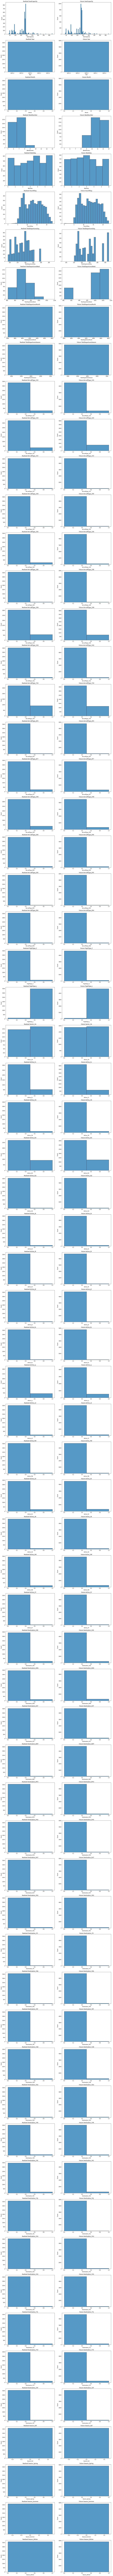

In [175]:
plot_feature_dists(test, selected_future_data)

### Validation dataset from February 2022 vs. Future dataset

100%|██████████| 68/68 [00:03<00:00, 19.61it/s]


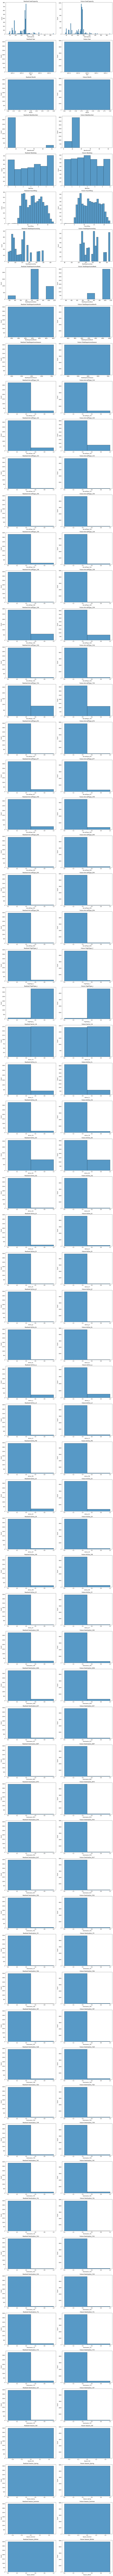

In [176]:
plot_feature_dists(validation, selected_future_data)

## Saving the data
We now save the preprocessed train, validation, test, and future datasets.
* `train.csv`
* `validation.csv`
* `test.csv`
* `future_preprocessed.csv`

In [177]:
def set_target_last(df, target):
    df = df.copy()
    tmp_target = df[target]
    df.drop(target, axis=1)
    df[target] = tmp_target
    return df

In [178]:
set_target_last(train, TARGET).to_csv(TRAIN_PATH, sep=',', decimal='.')
set_target_last(validation, TARGET).to_csv(VALIDATION_PATH, sep=',', decimal='.')
set_target_last(test, TARGET).to_csv(TEST_PATH, sep=',', decimal='.')
selected_future_data.to_csv(FUTURE_PATH, sep=',', decimal='.')